# Generate Seasonal Medians of Solar Irradiace Across Australia

* **Products used:**
[Solar Irradiance](https://dapds00.nci.org.au/thredds/catalog/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/latest/catalog.html)

## Background

Surface solar irradiance measurements are increasingly critical to the solar energy industry and are important to evaluate weather and climate model.Solar irradiance is the power per unit area received from the sun in the form of electromagnetic radiation measured in Watt per square metre (W/m2). 

Bureau of Meteorology (BoM) employed the Heliosat-4 radiation model (Qu et al, 2017) as implemented by Mines ParisTech (Gschwind et. al., 2020) to estimate downwelling solar radiation parameters. Heliosat-4 uses estimates of cloud properties derived from satellite observations, estimates of aerosol optical depth, and forecasts of atmospheric ozone and water vapour to estimate instantaneous surface global solar irradiance, known as global horizontal irradiance (GHI) in units of W/m2. Heliosat-4 also produces estimates of the instantaneous intensity of surface direct horizontal irradiance (BHI) in units of W/m2, from which the solar direct beam radiation falling on a surface normal to the beam, known as the direct normal irradiance (DNI) with units W/m2 is calculated. The daily global solar exposure (also known as "daily solar insolation" or "daily radiant exposure") is the integral of surface downwelling shortwave flux in air during a day in units of megajoules per square metre (MJ/m2). 

For further detail on the solar irradiance products, please see the [Gridded satellite solar observations project: Implementation of Heliosat-4 and the application of bias correction](http://www.bom.gov.au/research/publications/researchreports/BRR-062.pdf) research report.  

## Description

This notebook demonstrates how to load, visualise and export medians of BoM's daily solar irradiance data for each three months within a year across Australia. It includes the following steps:
1. Access daily solar irradiance products from NCI's THREDDS server and generate temporal aggregation
2. Visualise the summarised solar irradiance measurements across Australia
3. Export the summarised data as GeoTiff files

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
import datacube
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
from dea_tools.plotting import display_map, rgb
from datacube.utils.cog import write_cog
from load_solar_irradiance import load_summarise_solar_irradiance
from pyproj import CRS

### Analysis parameters

We define a few parameters for the data query and download:
* lat_range: The latitude range to analyse, e.g. (-44.51,-10.101)
* lon_range: The longitude range to analyse, e.g. (111.96,154.67).
* time_range: The date range to analyse, e.g. ('2022-01-01', '2022-12-31')
* timestep: timestep for temporal aggregation, e.g. '2M' for 2 months frequency resampled from month start dates
* var_names: List of product measurement names to query, e.g. ['daily_integral_of_surface_global_irradiance','daily_integral_of_direct_normal_irradiance'].  

Here we define the latitude and longitude ranges to cover entire Australia. To limit data loaded in memory, we query the half year data:

In [2]:
# Define the analysis region (Lat-Lon box)
lat_range = (-43.651,-10.701)
lon_range = (112.920,153.612)

# Define the time window
time_range = ("2022-01-01", "2022-06-30")

timestep='3MS'

# Define measurements to query
var_names=['daily_integral_of_surface_global_irradiance']

## View the queried location

The solar farm is located in NSW:

In [3]:
display_map(x=lon_range, y=lat_range)

## Load data and generate seasonal medians

We create and use a function `load_summarise_solar_irradiance` to load the daily irradiance data and generate medians for each three-month season using the previously defined parameters. After the loading and generation is complete we print out the loaded dataset. Note this may take up to a few minutes to finish.

In [4]:
%%time
# Retrieve surface soil moisture using query parameters
mean_solar_irrd = load_summarise_solar_irradiance(lat_range, lon_range, time_range, var_names,timestep)
mean_solar_irrd

Loading daily observations...


  1%|          | 1/181 [00:01<05:37,  1.87s/it]

Dataset time attribute out of queried time range, skipping it...


100%|██████████| 181/181 [01:11<00:00,  2.53it/s]


merging dataset...
resampling dataset...
CPU times: user 37.6 s, sys: 8.73 s, total: 46.3 s
Wall time: 5min 38s


<xarray.Dataset>
Dimensions:                                      (time: 2, latitude: 1648,
                                                  longitude: 2035)
Coordinates:
  * latitude                                     (latitude) float32 -43.64 .....
  * longitude                                    (longitude) float32 112.9 .....
    crs                                          int32 -2147483647
  * time                                         (time) datetime64[ns] 2022-0...
Data variables:
    daily_integral_of_surface_global_irradiance  (time, latitude, longitude) float64 ...
Attributes: (12/55)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  The following acknowledgement is require...
    cdm_data_type:                   grid
    comment:                         Solar radiation data derived from satell...
    contributor_name:                Mines ParisTech; Commonwealth of Austral...
    ...                              ...
    source:                          IDE00326.202201011830.nc [uuid: dc269487...
    uuid:                            c85fd455-49f1-4e5b-a0a8-40b1bdc3ed3a
    date_created:                    20220427T044245Z
    quality:                         0
    quality_meaning:                 0: no_known_issues 1: medium 2: low 4: poor
    history:                         heliosat-4; post_process_p1s.py, post_pr...

### Plot the seasonal medians

We can plot the temporal medians to compare across different seasons:

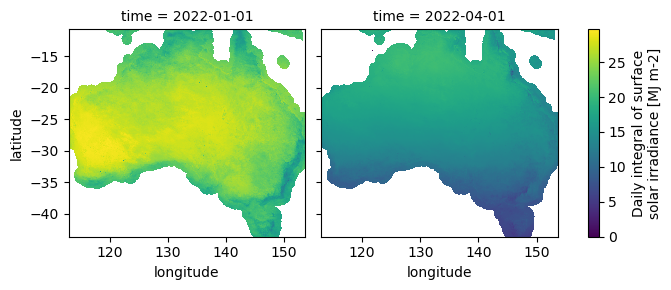

In [5]:
mean_solar_irrd.daily_integral_of_surface_global_irradiance.plot(col='time')

### Export as Geotiff

We can export the monthly data as GeoTIFF files to the disk using the datacube.utils.cog function`write_cog`:

In [6]:
# Get the CRS
crs=CRS.from_cf(mean_solar_irrd.crs.attrs)

# assign crs
if mean_solar_irrd.rio.crs is None:
    mean_solar_irrd.rio.write_crs(crs, inplace=True)
    
# export as geotiff
for i in range(len(mean_solar_irrd.time)):

    # We will use the date of the satellite image to name the GeoTIFF
    date = mean_solar_irrd.isel(time=i).time.dt.strftime('%Y-%m').data
    print(f'Writing {date}')

    # Convert current time step into a `xarray.DataArray`
    singletimestamp_da = mean_solar_irrd.isel(time=i).to_array()

    # Write GeoTIFF
    write_cog(singletimestamp_da,
              fname=f'{date}.tif',
              overwrite=True)

Writing 2022-01
Writing 2022-04


## Next steps

When you are done, if you would like to do the analysis for another location or time range, return to the "Analysis parameters" cell, modify the parameters and rerun the analysis.

***

## Additional information

**License:** The code in this notebook and its dependent modules is licensed under the [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/) license. 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2023

**Compatible datacube version:** 

In [7]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)